In [1]:
import os
import sys
import random
import warnings


import numpy as np
import pandas as pd




from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, UpSampling2D,Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

import imageio



/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def randomContinuous(n, step, x0):
    steps = [0]
    values = [x0]
    for i in range(1,n):
        gradient = random.normalvariate(0, 1)
        steps.append(i*step)
        values.append(gradient*step + values[len(values)-1])
    return steps, values

In [6]:
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) 
    return lerp(x1,x2,v) 

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

lin = np.linspace(0,2,256,endpoint=False)
x,y = np.meshgrid(lin,lin)

im_p = perlin(x,y,seed=random.randint(5,20))

In [7]:
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)



def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))


In [96]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

def elastoperlin_transformation(im ,mask,elast, perl, shape):
    lin = np.linspace(0,1,shape[0],endpoint=False)
    a,b = np.meshgrid(lin,lin)
    if perl:
        im_p = perlin(a,b,seed=random.randint(1,20000))
        im_p = np.abs(im_p)
        im_p = np.array((normalize(im_p)*5000), dtype = np.uint8)
        im_p = np.concatenate((im_p[...,None], im_p[...,None],im_p[...,None]), axis=2)
        im = im + im_p
    if elast:
        #coller im et mask
        im = elastic_transform(im,im.shape[1]*2,im.shape[1]*0.1,im.shape[1]*0.08) 
        #décoller im et mask
    im = cv2.copyMakeBorder(im,92,92,92,92,cv2.BORDER_REFLECT) 
    # 92 représente la marge rognée par les convolutions successives
    return im, mask

In [20]:
im = cv2.imread('DATA/imtest.png')
imaskdivision(im,im,(132,132),0)

2


(array([[[  3,   3,   3],
         [  2,   2,   2],
         [  3,   3,   3],
         ...,
         [103, 103, 103],
         [102, 102, 102],
         [ 98,  98,  98]],
 
        [[  2,   2,   2],
         [  3,   3,   3],
         [  3,   3,   3],
         ...,
         [103, 103, 103],
         [101, 101, 101],
         [ 96,  96,  96]],
 
        [[  3,   3,   3],
         [  3,   3,   3],
         [  3,   3,   3],
         ...,
         [108, 108, 108],
         [109, 109, 109],
         [ 99,  99,  99]],
 
        ...,
 
        [[  7,   7,   7],
         [  6,   6,   6],
         [  6,   6,   6],
         ...,
         [  2,   2,   2],
         [  2,   2,   2],
         [  3,   3,   3]],
 
        [[  6,   6,   6],
         [  5,   5,   5],
         [  5,   5,   5],
         ...,
         [  3,   3,   3],
         [  3,   3,   3],
         [  2,   2,   2]],
 
        [[  7,   7,   7],
         [  6,   6,   6],
         [  5,   5,   5],
         ...,
         [  2,   2,   2],
  

In [19]:
def imaskdivision(im,mask,shape, padding):
    # padding est la taille de la marge non masquée (92)
    # shape est la shape maximale d'un echantillon (132,132) dans notre cas
    heightDiv = int(np.ceil(float(im.shape[0])/float(shape[0])))
    print heightDiv
    return im,mask

def dataAugmentation(im, mask, rate):
    train = []
    labels = []
    for i in range(rate):
        imtemp, masktemp = elastoperlin_transformation(im, mask, True, True,np.shape(im[:,:,0]))
        ims, masks = imaskdivision(imtemp, masktemp,(132,132),92)
        for im,mask in ims,masks:
            train.append(im)
            labels.append(mask)
    return train , labels        
    
        

In [31]:
# Initialisation des variables
height = 316
width = 316
depth = 3
batchsize = 1
size_augmented = 440
kernel3x3= (3,3)


In [37]:
def get_crop_shape(target, refer):
        # width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)

In [1]:
def weightLoss(y_true, y_pred):
    [mask, weight] = tf.unstack(y_true, 2, axis=3)
    weighted_pred = y_pred*weight
    weighted_mask = mask*weight
    return binary_crossentropy(weighted_mask, weighted_pred)

In [88]:
inputLayer = Input(( height, width, depth))

normalise = Lambda(lambda x: x / 255) (inputLayer)

conv11 = Conv2D(32, kernel3x3, padding='valid', activation='relu')(normalise)
conv12 = Conv2D(32, kernel3x3, padding='valid', activation='relu')(conv11)
pool1 = MaxPooling2D((2,2))(conv12)
conv21 = Conv2D(64, kernel3x3, padding='valid', activation='relu')(pool1)
conv22 = Conv2D(64, kernel3x3, padding='valid', activation='relu')(conv21)
pool2 = MaxPooling2D((2,2))(conv22)
conv31 = Conv2D(128, kernel3x3, padding='valid', activation='relu')(pool2)
conv32 = Conv2D(128, kernel3x3, padding='valid', activation='relu')(conv31)
pool3 = MaxPooling2D((2,2))(conv32)
conv41 = Conv2D(256, kernel3x3, padding='valid', activation='relu')(pool3)
conv42 = Conv2D(256, kernel3x3, padding='valid', activation='relu')(conv41)
pool4 = MaxPooling2D((2,2))(conv42)
conv51 = Conv2D(512, kernel3x3, padding='valid', activation='relu')(pool4)
conv52 = Conv2D(512, kernel3x3, padding='valid', activation='relu')(conv51)



upconv1 = UpSampling2D(size=(2, 2))(conv52)
ch, cw = get_crop_shape(conv42, upconv1)
cropconv4 = Cropping2D(cropping=(ch,cw))(conv42)
up1   = concatenate([upconv1, cropconv4], axis=3)
conv61 = Conv2D(256, kernel3x3, padding="valid", activation="relu")(up1)
conv62 = Conv2D(256, kernel3x3, padding="valid", activation="relu")(conv61)


upconv2 = UpSampling2D(size=(2, 2))(conv62)
ch, cw = get_crop_shape(conv32, upconv2)
cropconv3 = Cropping2D(cropping=(ch,cw))(conv32)
up2  = concatenate([upconv2, cropconv3], axis=3)
conv71 = Conv2D(128, kernel3x3, padding="valid", activation="relu")(up2)
conv72 = Conv2D(128, kernel3x3, padding="valid", activation="relu")(conv71)


upconv3 = UpSampling2D(size=(2, 2))(conv72)
ch, cw = get_crop_shape(conv22, upconv3)
cropconv2 = Cropping2D(cropping=(ch,cw))(conv22)
up3  = concatenate([upconv3, cropconv2], axis=3)
conv81 = Conv2D(64, kernel3x3, padding="valid", activation="relu")(up3)
conv82 = Conv2D(64, kernel3x3, padding="valid", activation="relu")(conv81)

upconv4 = UpSampling2D(size=(2, 2))(conv82)
ch, cw = get_crop_shape(conv12, upconv4)
cropconv1 = Cropping2D(cropping=(ch,cw))(conv12)
up4  = concatenate([upconv4, cropconv1], axis=3)
conv91 = Conv2D(32, kernel3x3, padding="valid", activation="relu")(up4)
conv92 = Conv2D(32, kernel3x3, padding="valid", activation="relu")(conv91)

outputconv = Conv2D(1, (1, 1), activation="sigmoid")(conv92)


u_net = Model(inputs= inputLayer, outputs = outputconv)

u_net.compile(optimizer='adam', loss='weightLoss')
#u_net.summary()

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

1/1 [==============================] - 1s 542ms/step


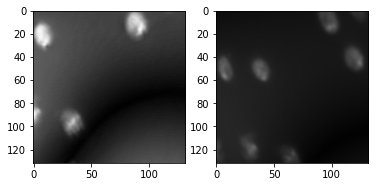

In [124]:

X_train = np.zeros((1, 316, 316, 3), dtype=np.uint8)
X_train[0,:,:] = elastoperlin_transformation(im ,True, True, (256,256))
p_test = u_net.predict(X_train, batch_size = 1, verbose=1)
p = np.reshape(p_test[0,:,:], (132,132))

plt.figure(1)
plt.subplot(121)
plt.imshow(p, interpolation="bicubic", cmap ="Greys")

plt.subplot(122)
plt.imshow(X_train[0,62:194,62:194,:],interpolation="bicubic", cmap ="Greys")
plt.show()
